In [2]:
import numpy as np
import os
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
width, height = 224, 224

# Define the base directory for training images
data_dir = r'C:\Users\SURENDHAN\Desktop\pro\colored_images'

# List all image paths in the 'train' directory
imagePaths = list(paths.list_images(data_dir))

data = []
labels = []

In [4]:
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]  # Get the class label from the folder name
    image = load_img(imagePath, target_size=(width, height))  # Load and resize image
    image = img_to_array(image)  # Convert image to array
    data.append(image)
    labels.append(label)

# Convert lists to numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# Normalize the image data to the range [0, 1]
data = data / 255.0

# Encode labels using LabelBinarizer (convert string labels to numeric)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Convert one-hot encoded labels back to class indices (optional)
labels = np.argmax(labels, axis=1)

# Split the data into training and validation sets (80% train, 20% validation)
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Ensure labels are in the correct integer format
train_labels = train_labels.astype('int32')
val_labels = val_labels.astype('int32')

print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")


Training data shape: (2924, 224, 224, 3)
Validation data shape: (732, 224, 224, 3)


In [5]:
# Create a custom CNN model with data augmentation
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    Dense(5, activation='softmax')  # 5 classes for diabetic retinopathy
])

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\SURENDHAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:

aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

aug.fit(train_data)


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    aug.flow(train_data, train_labels, batch_size=32),
    epochs=5,  
    validation_data=(val_data, val_labels),
    callbacks=[early_stopping]
)

val_loss, val_acc = model.evaluate(val_data, val_labels)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")


c:\Users\SURENDHAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.4755 - loss: 9.6012 - val_accuracy: 0.2036 - val_loss: 1.9074
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.5645 - loss: 1.6326 - val_accuracy: 0.2691 - val_loss: 1.6353
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.5995 - loss: 1.4664 - val_accuracy: 0.1503 - val_loss: 2.8260
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.6389 - loss: 1.1699 - val_accuracy: 0.2896 - val_loss: 1.7220
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.6575 - loss: 1.1442 - val_accuracy: 0.6052 - val_loss: 1.1400
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.5718 - loss: 1.1846
Validation Loss: 1.1399931907653809
Validation Accuracy: 0.6051912307739258


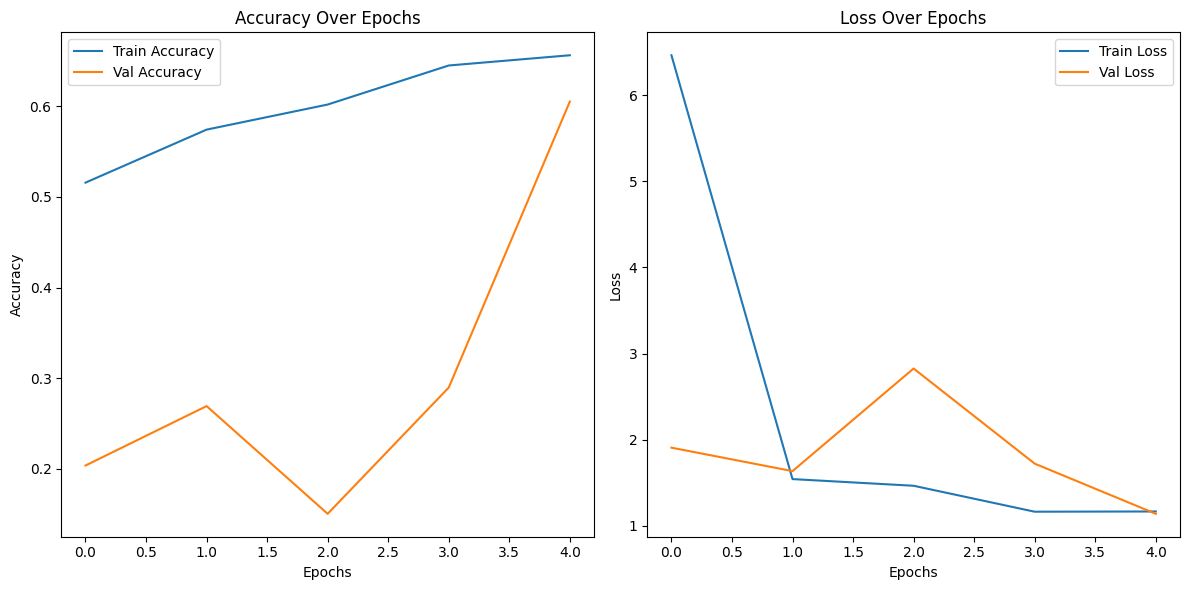

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()